## Importing libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

## Data loading & Initial analysis

In [ ]:
data = pd.read_csv("/Traffic.csv")

In [ ]:
data.head() #head of data

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal


In [ ]:
data.info() # information of dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   object
 1   Date               2976 non-null   int64 
 2   Day of the week    2976 non-null   object
 3   CarCount           2976 non-null   int64 
 4   BikeCount          2976 non-null   int64 
 5   BusCount           2976 non-null   int64 
 6   TruckCount         2976 non-null   int64 
 7   Total              2976 non-null   int64 
 8   Traffic Situation  2976 non-null   object
dtypes: int64(6), object(3)
memory usage: 209.4+ KB


In [ ]:
data.describe() # statistical parameters of dataset

,Date,CarCount,BikeCount,BusCount,TruckCount,Total
count,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000,2976.000000
mean,16.000000,68.696573,14.917339,15.279570,15.324933,114.218414
std,8.945775,45.850693,12.847518,14.341986,10.603833,60.190627
min,1.000000,6.000000,0.000000,0.000000,0.000000,21.000000
25%,8.000000,19.000000,5.000000,1.000000,6.000000,55.000000
50%,16.000000,64.000000,12.000000,12.000000,14.000000,109.000000
75%,24.000000,107.000000,22.000000,25.000000,23.000000,164.000000
max,31.000000,180.000000,70.000000,50.000000,40.000000,279.000000


## EDA - Exploratory Data Analysis

In [ ]:
# checking for any missing values
def missingValues(data):
    missing_values = data.isnull().sum()
    missing_values
    print("Columns with Missing Values:")
    print(missing_values[missing_values > 0])
missingValues(data)

Columns with Missing Values:
Series([], dtype: int64)


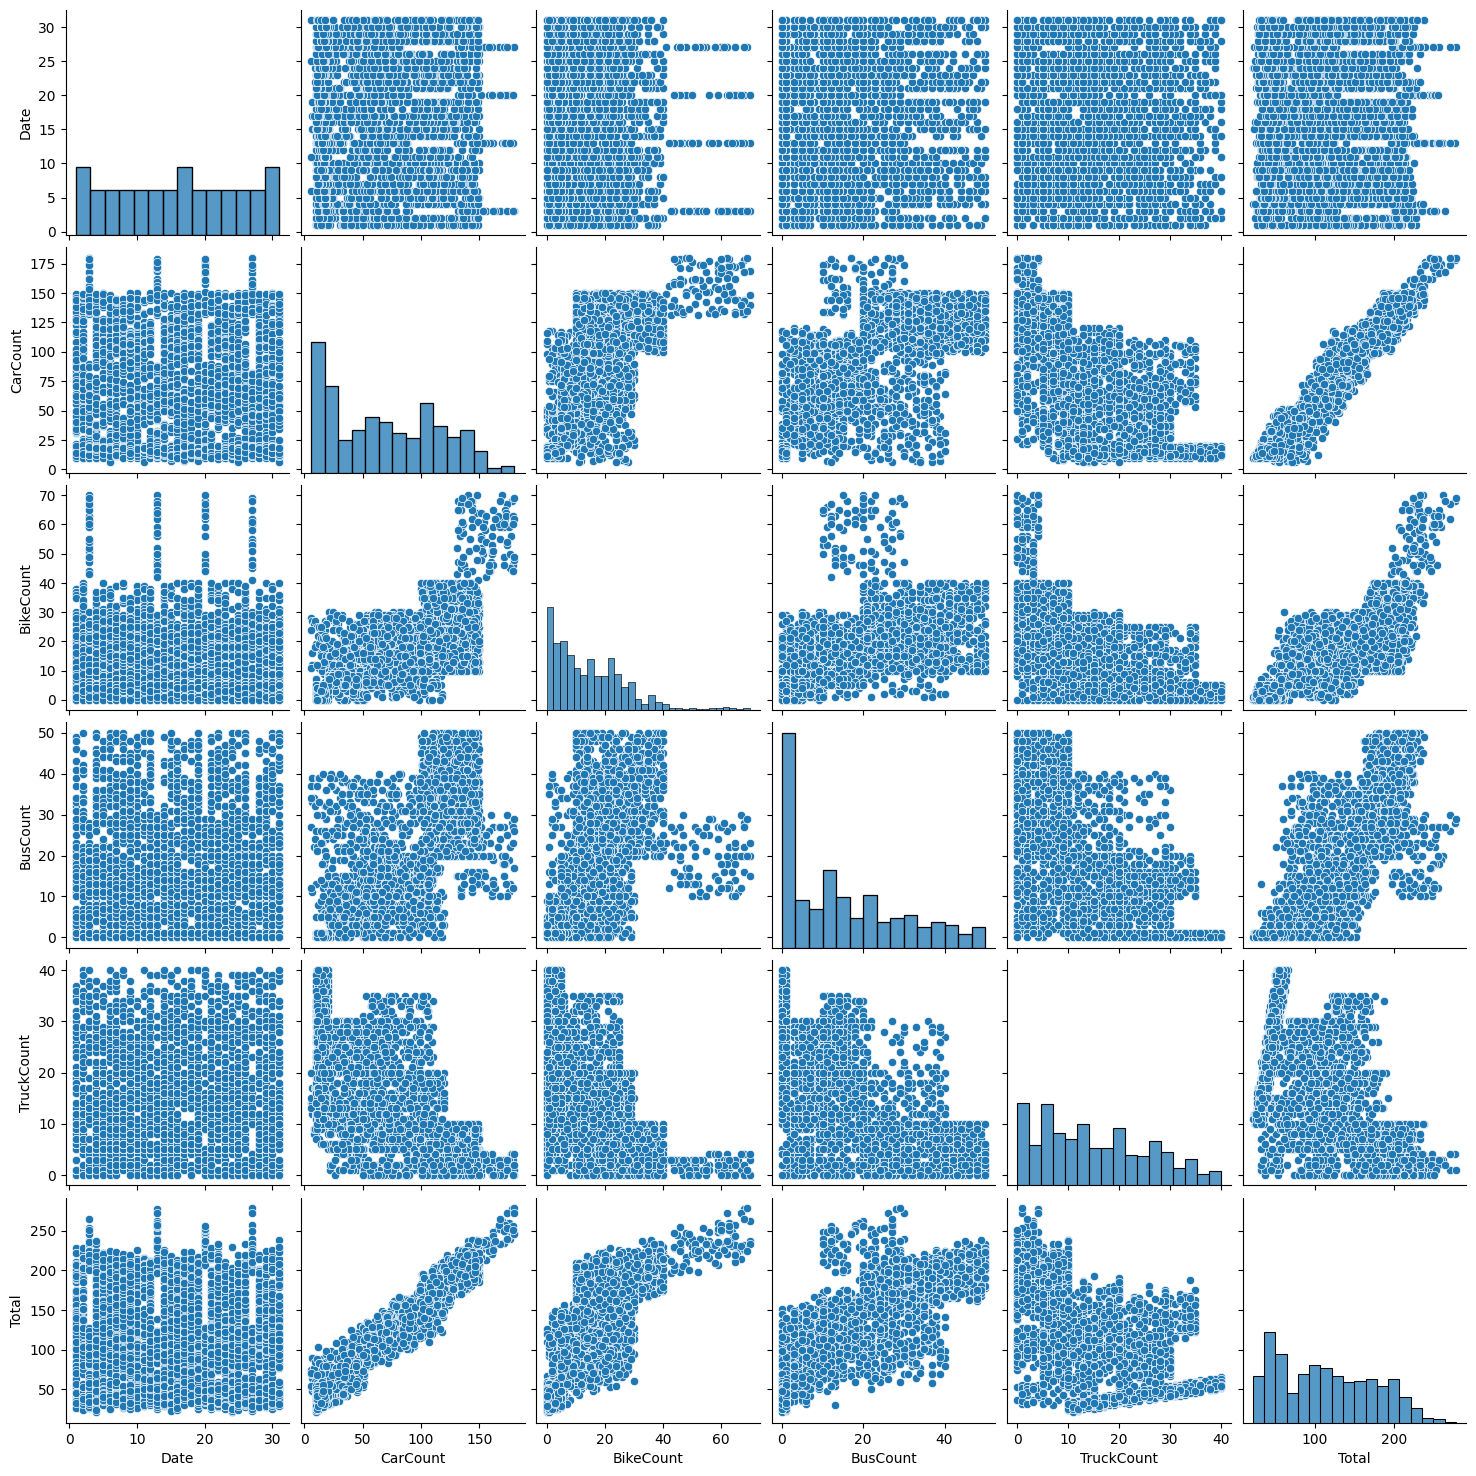

In [ ]:
# Pairplot for numerical columns
def pairPlot(data):
    sns.pairplot(data)
    plt.show()
pairPlot(data)

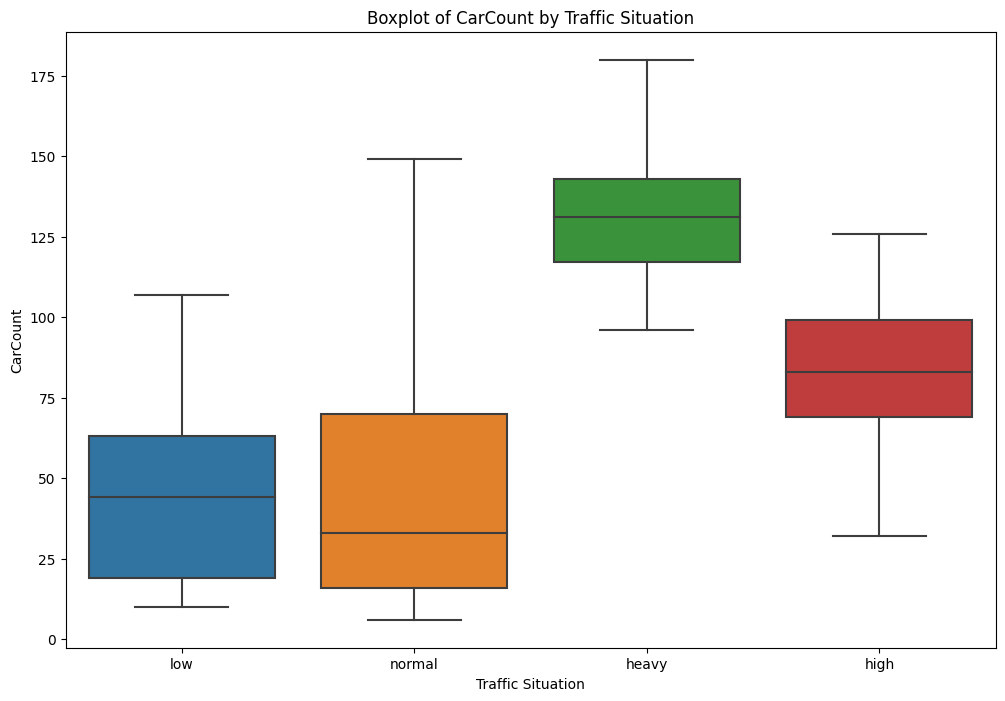

In [ ]:
# Boxplot for traffic situations and numerical columns
def boxPlots(data):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Traffic Situation', y='CarCount', data=data)
    plt.title('Boxplot of CarCount by Traffic Situation')
    plt.show()
boxPlots(data)

In [ ]:
numerical_columns = data.select_dtypes(include=['int64']).columns

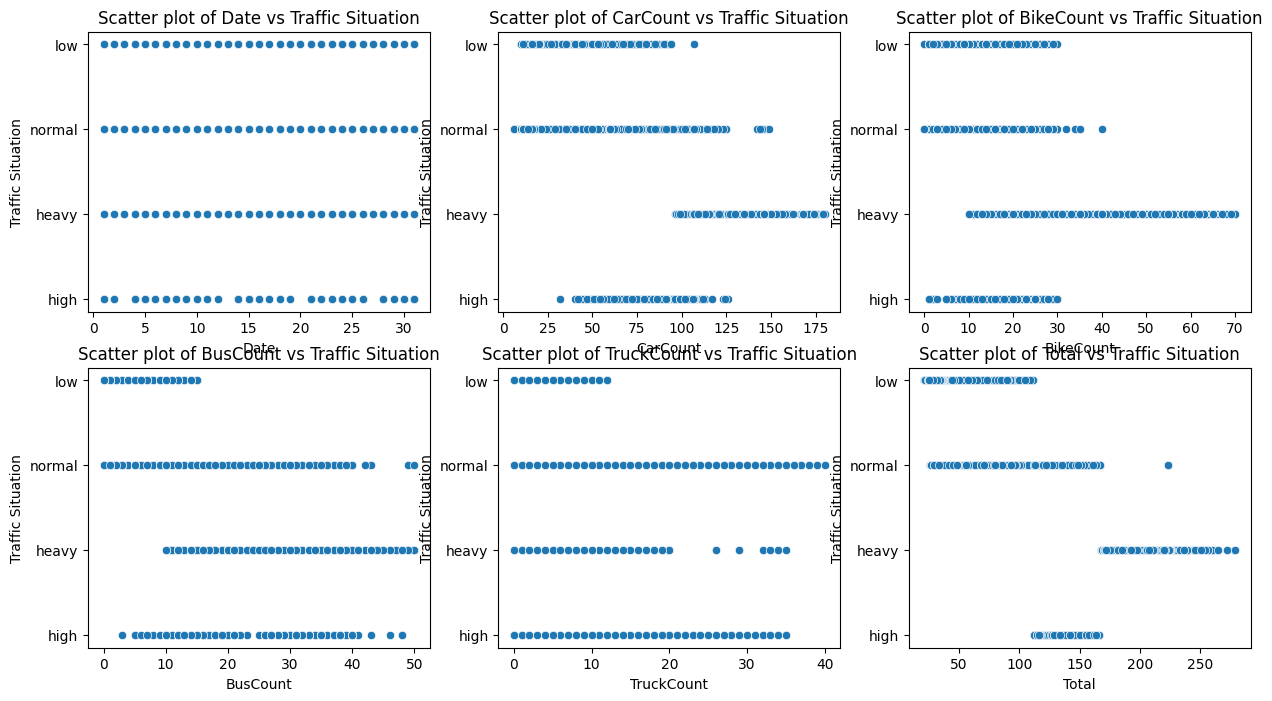

In [ ]:
# Scatter plots for numerical columns
def scatterPlots(numerical_columns,data):
    plt.figure(figsize=(15, 8))
    for i, column in enumerate(numerical_columns, 1):
        plt.subplot(2, 3, i)
        sns.scatterplot(x=data[column], y=data['Traffic Situation'])
        plt.title(f'Scatter plot of {column} vs Traffic Situation')
    plt.show()
scatterPlots(numerical_columns,data)

In [ ]:
def removeOutliers(data,numerical_columns):
    Q1 = data[numerical_columns].quantile(0.25)
    Q3 = data[numerical_columns].quantile(0.75)
    IQR = Q3 - Q1
    filtered_entries_iqr = ~((data[numerical_columns] < (Q1 - 1.5 * IQR)) | (data[numerical_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
    df = data[filtered_entries_iqr]
    return df
df = removeOutliers(data,numerical_columns)

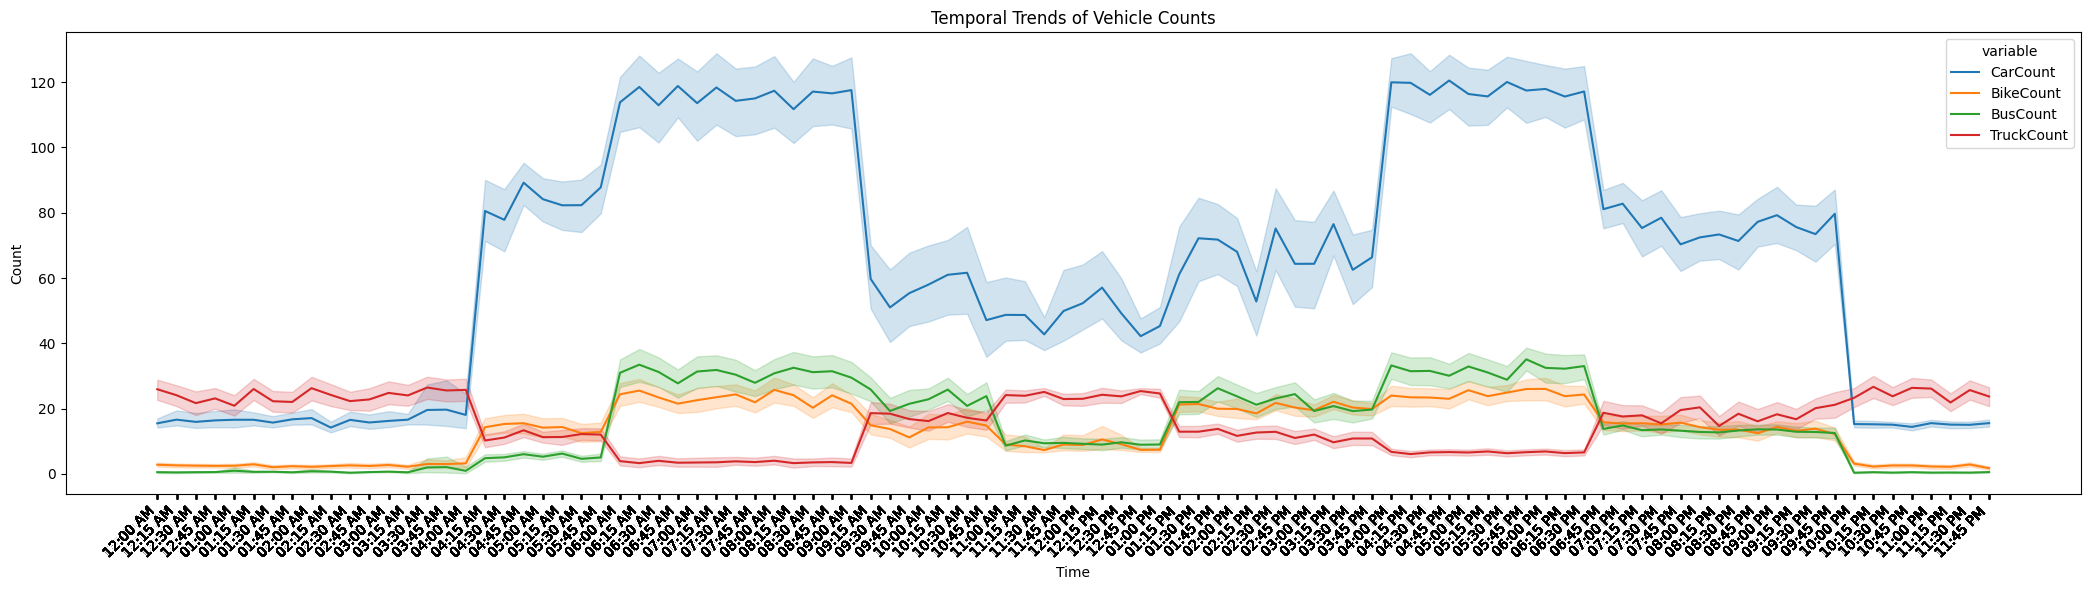

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Line plot for CarCount, BikeCount, BusCount, TruckCount
plt.figure(figsize=(26, 6))
sns.lineplot(x='Time', y='value', hue='variable', data=pd.melt(df[['Time', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount']], ['Time']))

# Adjust X-axis ticks to display only the time part
plt.xticks(df['Time'], labels=df['Time'].dt.strftime('%I:%M %p'), rotation=45, ha='right')

plt.title('Temporal Trends of Vehicle Counts')
plt.xlabel('Time')
plt.ylabel('Count')
plt.show()


Class Distribution:
normal    1669
heavy      605
high       321
low        304
Name: Traffic Situation, dtype: int64


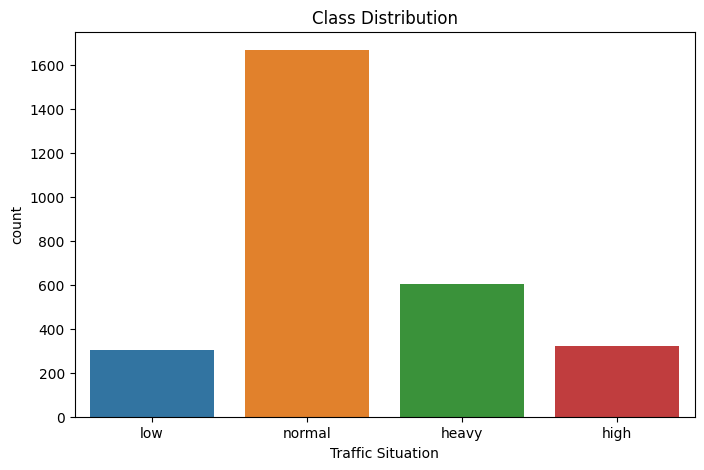

In [ ]:
def classDistribution(df):
    class_counts = df['Traffic Situation'].value_counts()
    print("Class Distribution:")
    print(class_counts)
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Traffic Situation', data=df)
    plt.title('Class Distribution')
    plt.show()
classDistribution(df)

<ipython-input-13-5a53ab88edd1>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


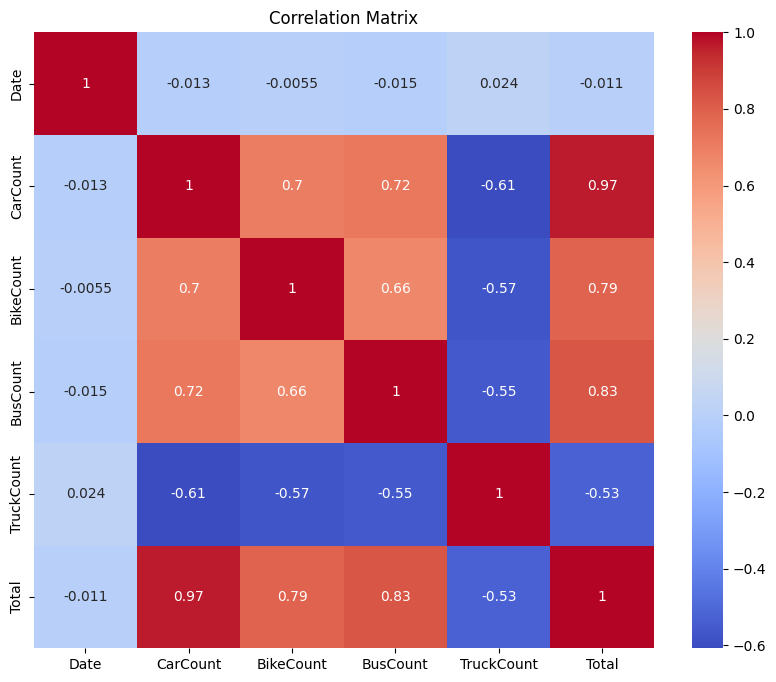

In [ ]:
# Correlation heatmap for numerical columns
def correlationMatrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()
correlationMatrix(df)

In [ ]:
df['Time'] = pd.to_datetime(df['Time'])

<ipython-input-14-1bfd8981fe14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = pd.to_datetime(df['Time'])


## Feature Engineering

## Circular Encoding - Time Column

In [ ]:
df['HourOfDay'] = df['Time'].dt.hour

# Apply circular encoding for the hour of the day
df['HourSin'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
df['HourCos'] = np.cos(2 * np.pi * df['HourOfDay'] / 24)

# Drop original 'Time' and 'HourOfDay' columns
df = df.drop(['Time', 'HourOfDay'], axis=1)

# Ensure 'Day of the week' is one-hot encoded
df = pd.get_dummies(df, columns=['Day of the week'])

# Ensure all columns are of numeric types for compatibility with SMOTE
df['Date'] = df['Date'].astype(float)  # Convert 'Date' to float if needed
float_columns = ['Day of the week_Monday', 'Day of the week_Saturday', 'Day of the week_Sunday',
                 'Day of the week_Thursday', 'Day of the week_Tuesday', 'Day of the week_Friday','Day of the week_Wednesday']

# Convert selected columns to float
df[float_columns] = df[float_columns].astype(float)


<ipython-input-15-87f24f5f8611>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HourOfDay'] = df['Time'].dt.hour
<ipython-input-15-87f24f5f8611>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HourSin'] = np.sin(2 * np.pi * df['HourOfDay'] / 24)
<ipython-input-15-87f24f5f8611>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2899 entries, 0 to 2975
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       2899 non-null   float64
 1   CarCount                   2899 non-null   int64  
 2   BikeCount                  2899 non-null   int64  
 3   BusCount                   2899 non-null   int64  
 4   TruckCount                 2899 non-null   int64  
 5   Total                      2899 non-null   int64  
 6   Traffic Situation          2899 non-null   object 
 7   HourSin                    2899 non-null   float64
 8   HourCos                    2899 non-null   float64
 9   Day of the week_Friday     2899 non-null   float64
 10  Day of the week_Monday     2899 non-null   float64
 11  Day of the week_Saturday   2899 non-null   float64
 12  Day of the week_Sunday     2899 non-null   float64
 13  Day of the week_Thursday   2899 non-null   float

In [ ]:
df.columns

Index(['Date', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total',
       'Traffic Situation', 'HourSin', 'HourCos', 'Day of the week_Friday',
       'Day of the week_Monday', 'Day of the week_Saturday',
       'Day of the week_Sunday', 'Day of the week_Thursday',
       'Day of the week_Tuesday', 'Day of the week_Wednesday'],
      dtype='object')

## Seperating Features and Target Variable

In [ ]:
X = df.drop('Traffic Situation', axis=1)
y = df['Traffic Situation']
le = LabelEncoder()
y = le.fit_transform(y)
# Assuming X is your feature matrix
imputer = SimpleImputer(strategy='mean')
X= imputer.fit_transform(X)

In [ ]:
unique_labels = np.unique(y)
print(unique_labels)

[0 1 2 3]


## SMOTE

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


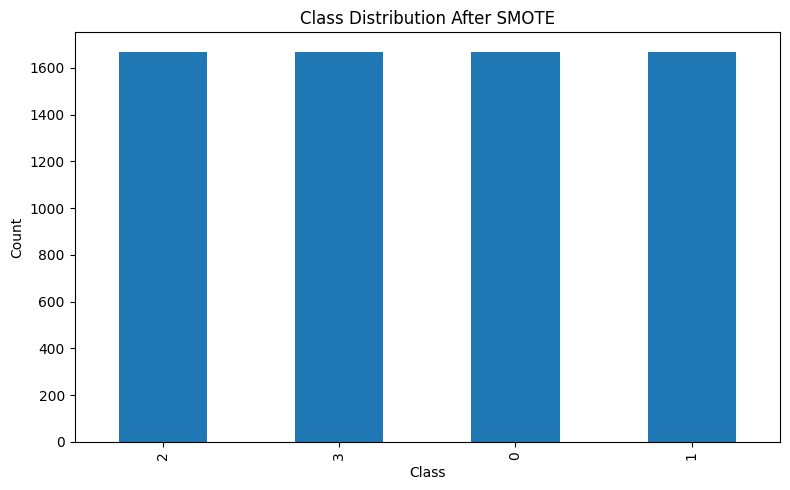

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

y_resampled_series = pd.Series(y_resampled)
resampled_class_counts = y_resampled_series.value_counts()
resampled_class_counts.plot(kind='bar', ax=ax)
ax.set_title('Class Distribution After SMOTE')
ax.set_xlabel('Class')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

## Train - Test splitting

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Classifiers

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
cl1 = LogisticRegression()
cl2 = RandomForestClassifier()
cl3 = SVC(probability=True)
cl4 = XGBClassifier()
cl5 = AdaBoostClassifier()

voting_cl = VotingClassifier(estimators = [('lr',cl1),('rf',cl2),('svc',cl3),
                                          ('xgb',cl4),('ada',cl5)], voting = 'hard')

voting_cl.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('svc', SVC(probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('ada', AdaBoostClassifier())])

In [ ]:
voting_pred = voting_cl.predict(X_test_scaled)
accuracy = accuracy_score(y_test, voting_pred)
accuracy

0.9752994011976048

In [ ]:
#Voting classfier using Cross_validation
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
for clf, label in zip([cl1,cl2,cl3,cl4,cl5],['lr','rf','svc','xgb','ada']):
    scores = cross_val_score(clf, X_train_scaled, y_train, scoring='accuracy', cv=5)
    print('Accuracy: ', (scores.mean(), label))

Accuracy:  (0.9147940074906368, 'lr')
Accuracy:  (0.9983146067415731, 'rf')
Accuracy:  (0.9464419475655431, 'svc')
Accuracy:  (0.9985018726591761, 'xgb')
Accuracy:  (0.5054307116104868, 'ada')


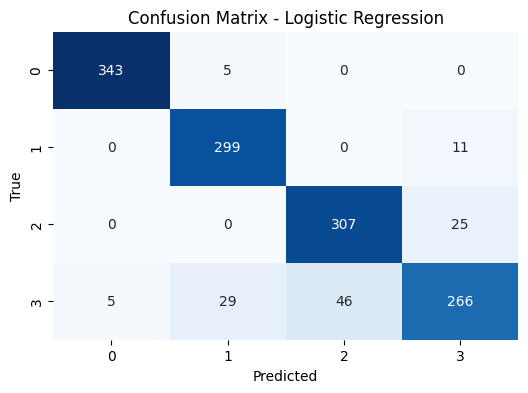

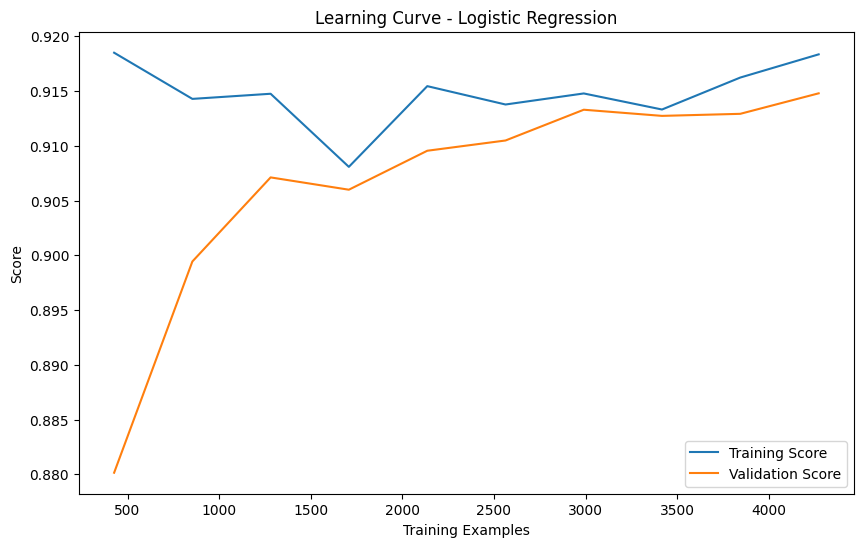

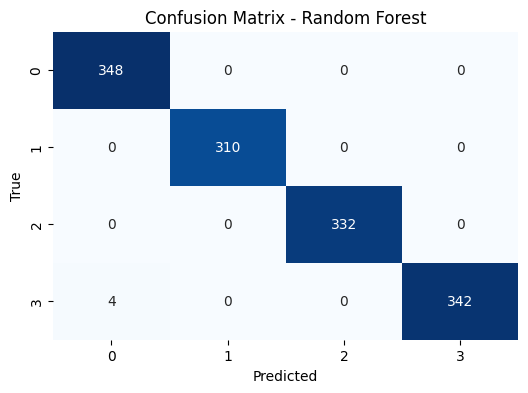

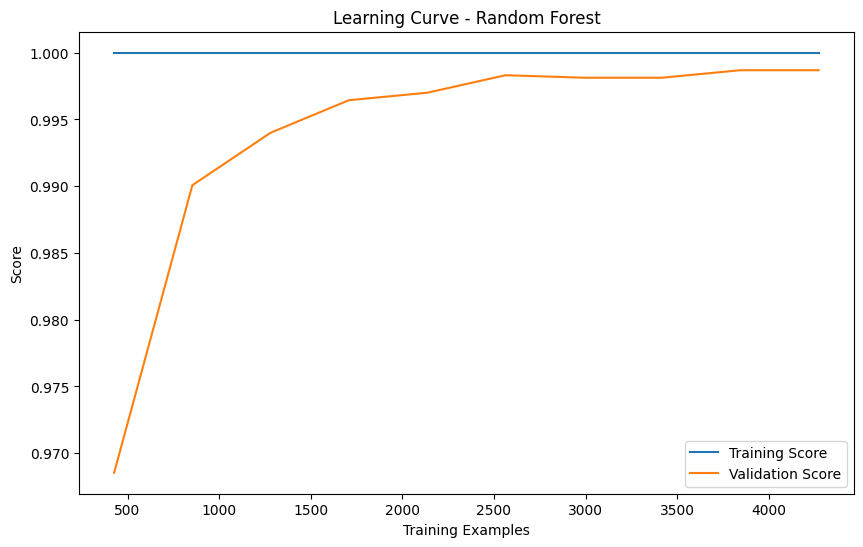

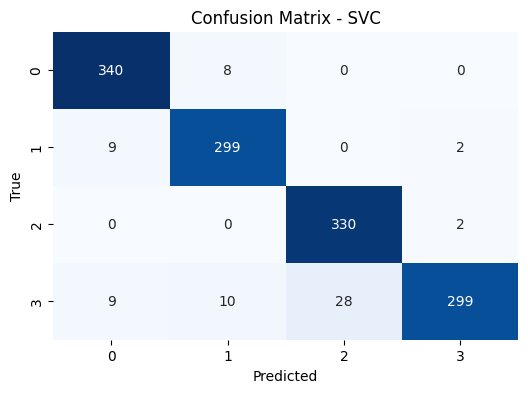

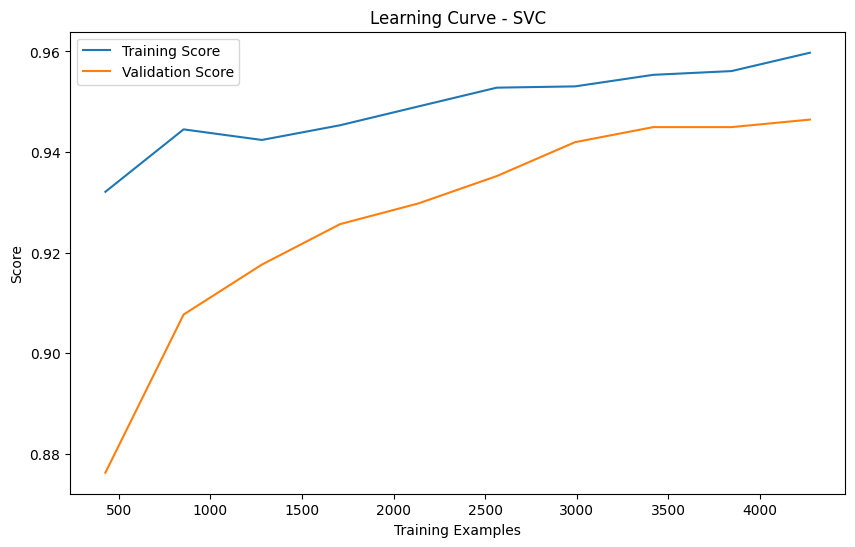

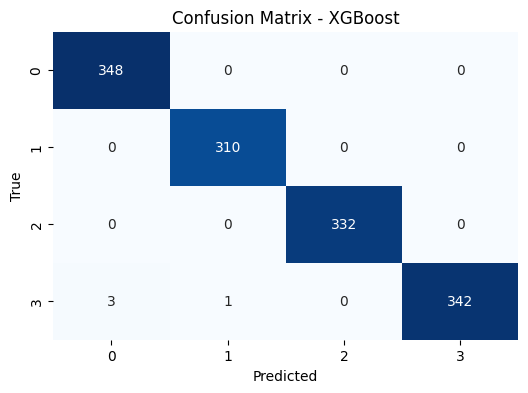

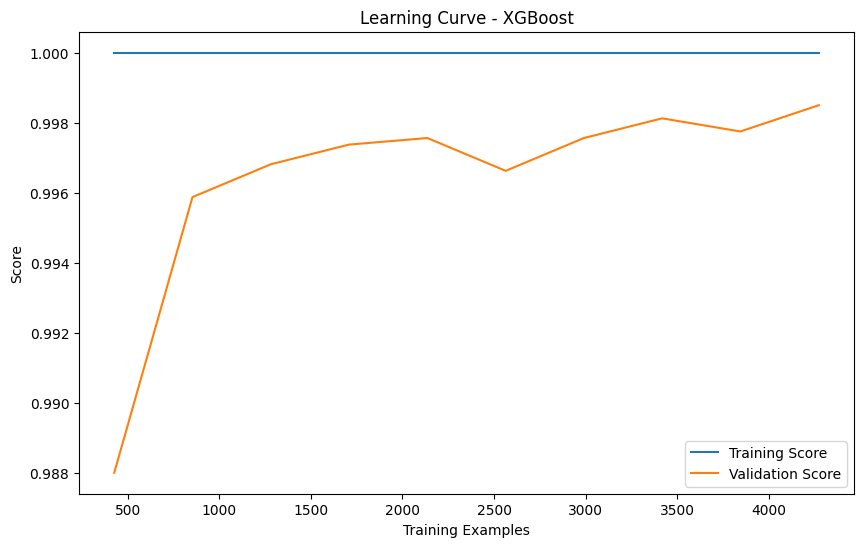

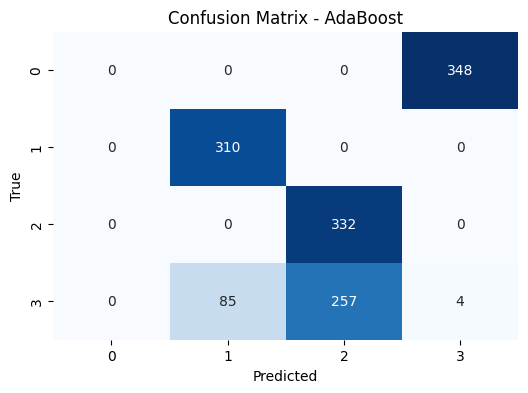

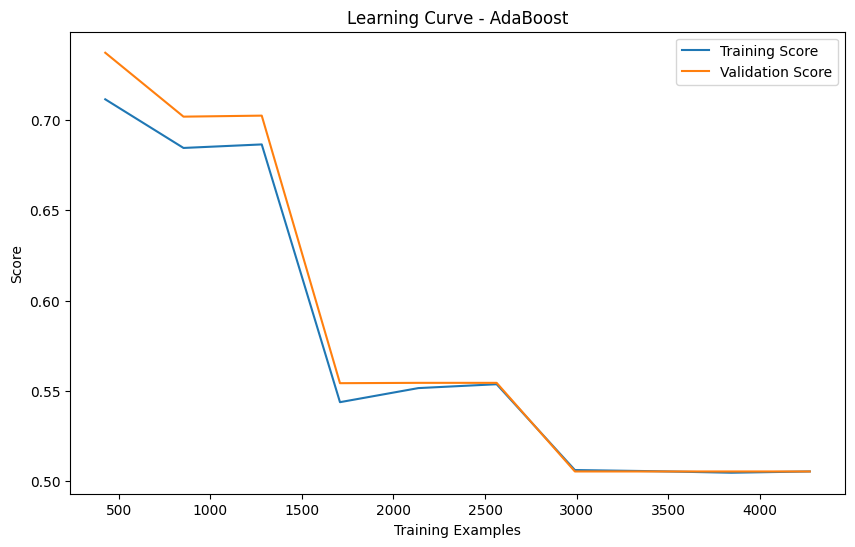

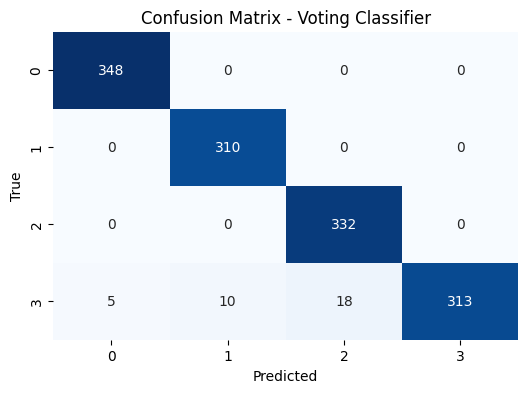

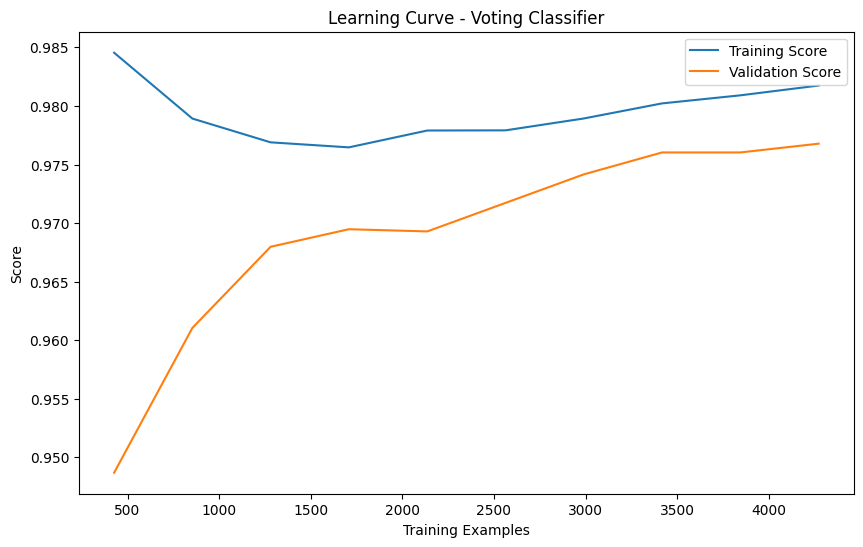

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

# Confusion Matrix and Learning Curve for Each Classifier

classifiers = [cl1, cl2, cl3, cl4, cl5, voting_cl]
labels = ['Logistic Regression', 'Random Forest', 'SVC', 'XGBoost', 'AdaBoost', 'Voting Classifier']

# Fit each classifier before using it for prediction
for clf, label in zip(classifiers, labels):
    clf.fit(X_train_scaled, y_train)

# Confusion Matrix and Learning Curve for Each Classifier

for clf, label in zip(classifiers, labels):
    # Confusion Matrix
    y_pred = clf.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X_train_scaled, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
    plt.title(f'Learning Curve - {label}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter Tuning for Each Classifier

# Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

grid_search_lr = GridSearchCV(cl1, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_lr.fit(X_train_scaled, y_train)

best_lr_classifier = grid_search_lr.best_estimator_

# Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(cl2, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

best_rf_classifier = grid_search_rf.best_estimator_

# SVC
param_grid_svc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid_search_svc = GridSearchCV(cl3, param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svc.fit(X_train_scaled, y_train)

best_svc_classifier = grid_search_svc.best_estimator_

# XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search_xgb = GridSearchCV(cl4, param_grid_xgb, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train_scaled, y_train)

best_xgb_classifier = grid_search_xgb.best_estimator_

# AdaBoost
param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_ada = GridSearchCV(cl5, param_grid_ada, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_ada.fit(X_train_scaled, y_train)

best_ada_classifier = grid_search_ada.best_estimator_

# Voting Classifier (if desired)
voting_cl.set_params(estimators=[
    ('lr', best_lr_classifier),
    ('rf', best_rf_classifier),
    ('svc', best_svc_classifier),
    ('xgb', best_xgb_classifier),
    ('ada', best_ada_classifier)
])




VotingClassifier(estimators=[('lr', LogisticRegression(C=100)),
                             ('rf',
                              RandomForestClassifier(max_depth=20,
                                                     min_samples_leaf=4,
                                                     min_samples_split=10)),
                             ('svc', SVC(C=10, probability=True)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=Non...
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...)),
                             ('ada',
                              AdaBoostClassifier(learning_rate=0.01,
                                                 n_estimators=200))])

In [ ]:
# Print Best Parameters for Each Classifier

print("Best Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("Best Parameters for SVC:", grid_search_svc.best_params_)
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("Best Parameters for AdaBoost:", grid_search_ada.best_params_)


Best Parameters for Logistic Regression: {'C': 100, 'penalty': 'l2'}
Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Parameters for SVC: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200}
Best Parameters for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 200}


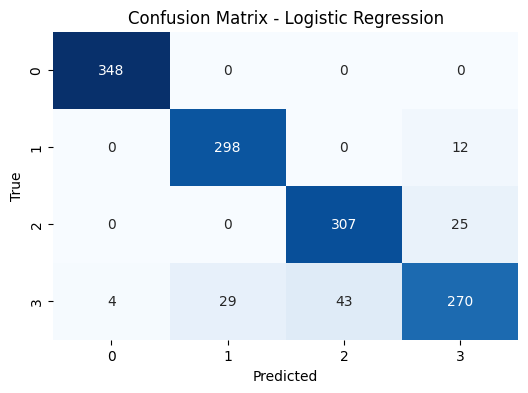

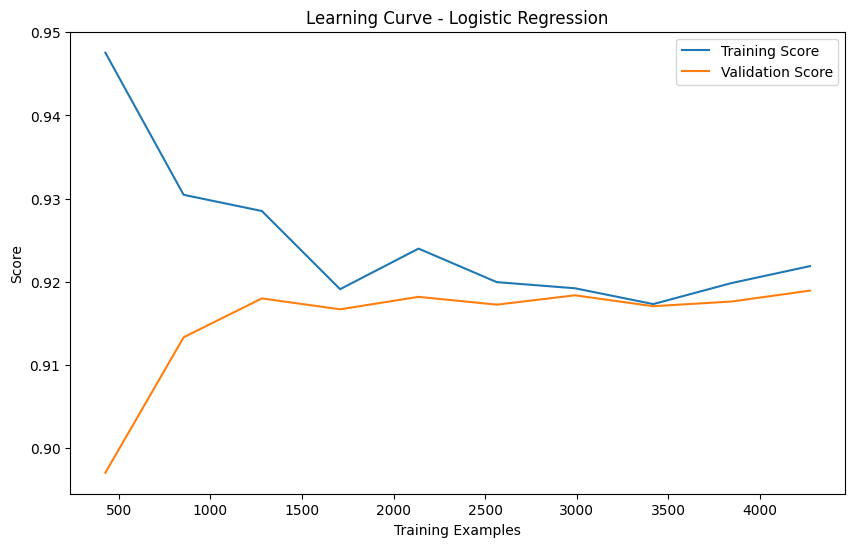

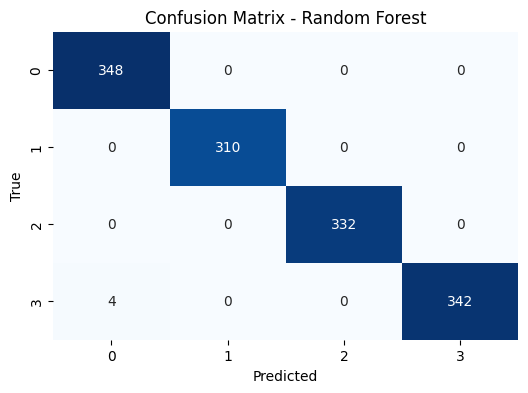

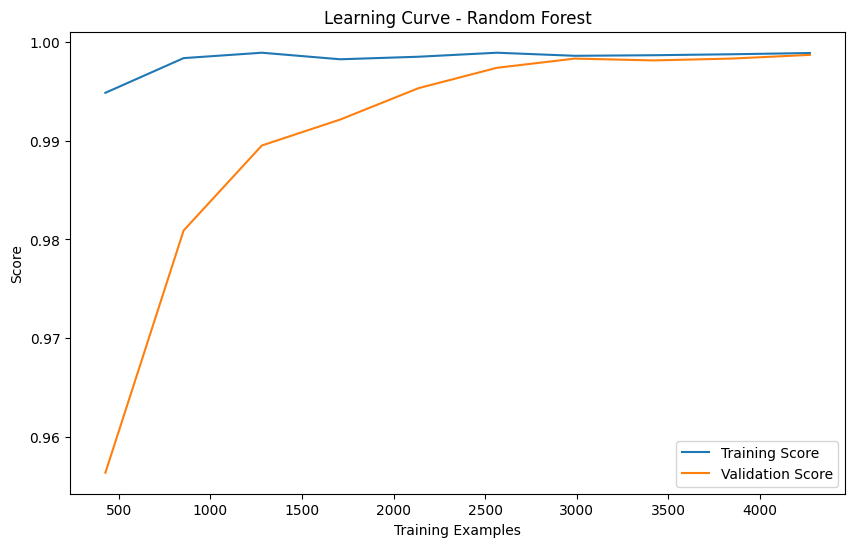

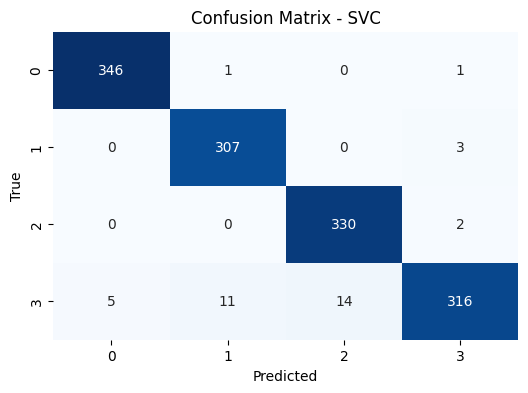

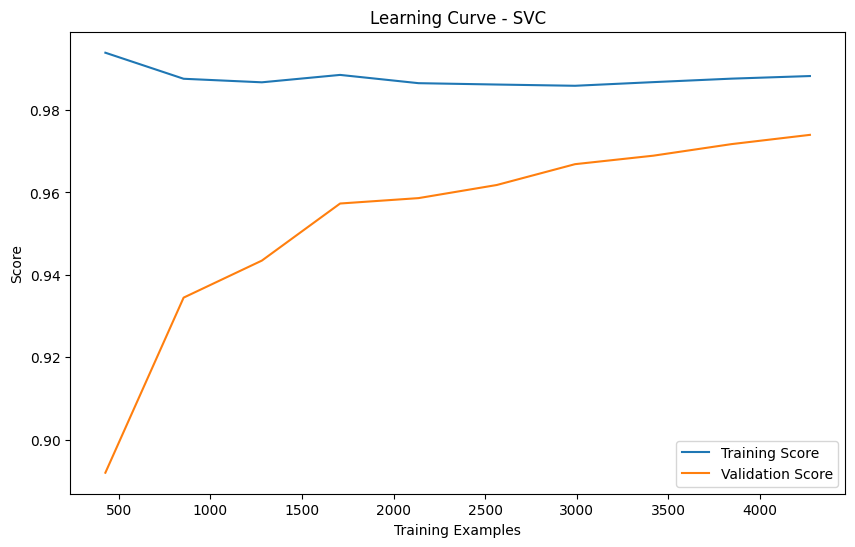

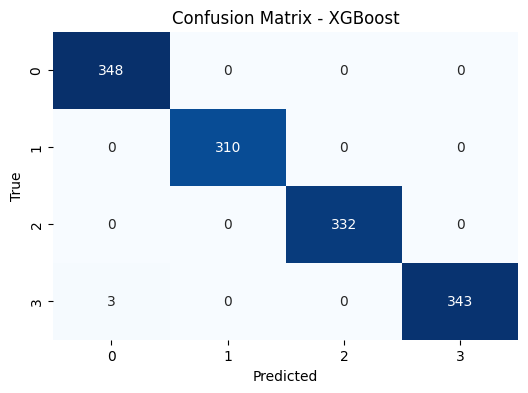

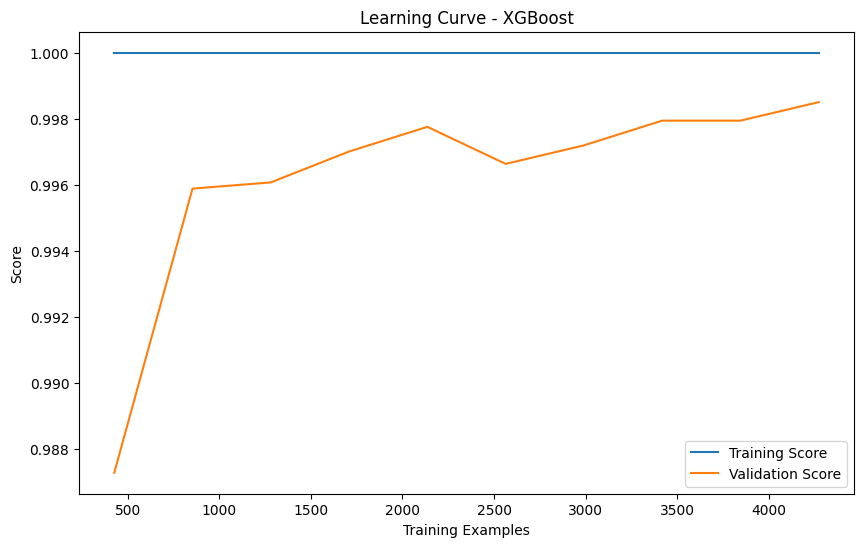

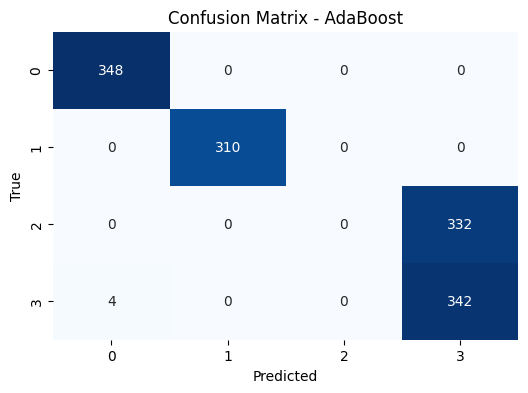

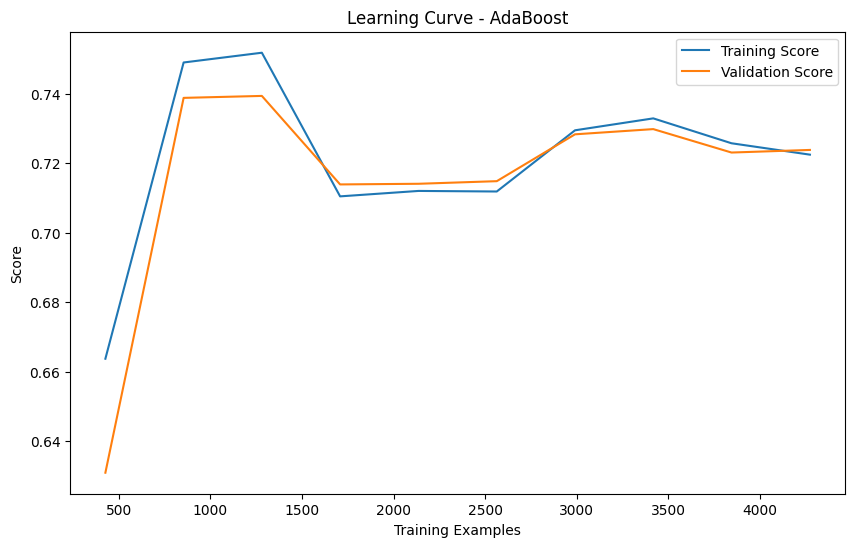

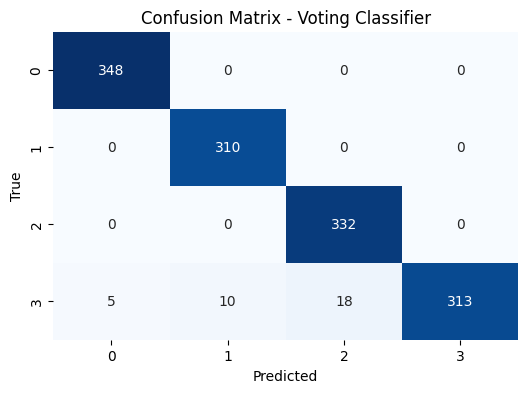

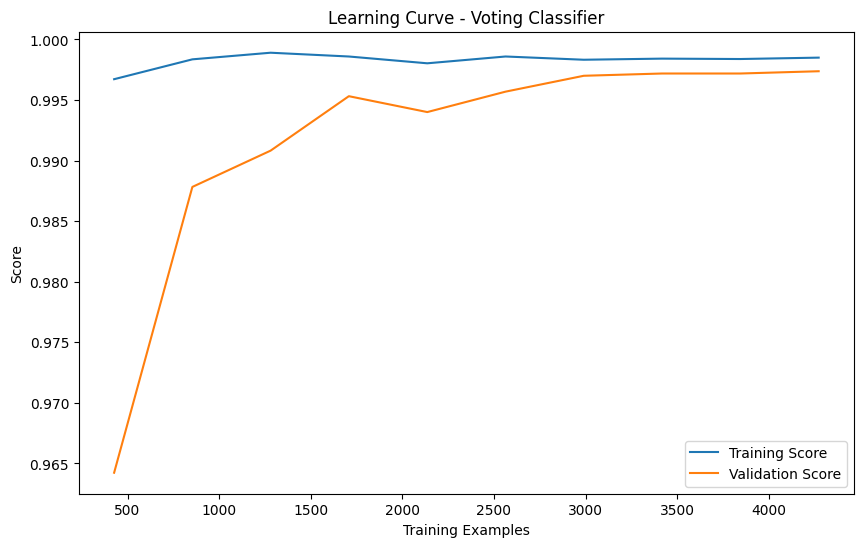

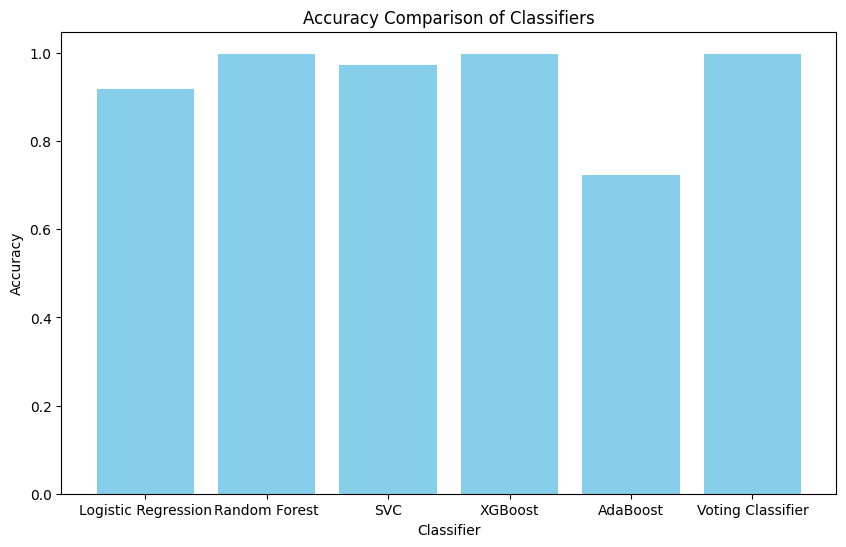

In [ ]:
# Plotting Metrics for Classifiers with Best Parameters

classifiers = [
    grid_search_lr.best_estimator_,
    grid_search_rf.best_estimator_,
    grid_search_svc.best_estimator_,
    grid_search_xgb.best_estimator_,
    grid_search_ada.best_estimator_,
    voting_cl
]

labels = ['Logistic Regression', 'Random Forest', 'SVC', 'XGBoost', 'AdaBoost', 'Voting Classifier']

# Confusion Matrix and Learning Curve for Each Classifier

for clf, label in zip(classifiers, labels):
    # Confusion Matrix
    y_pred = clf.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X_train_scaled, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
    plt.title(f'Learning Curve - {label}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

# Accuracy Comparison Plot

accuracy_scores = []

for clf, label in zip(classifiers, labels):
    scores = cross_val_score(clf, X_train_scaled, y_train, scoring='accuracy', cv=5)
    accuracy_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.bar(labels, accuracy_scores, color='skyblue')
plt.title('Accuracy Comparison of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.show()


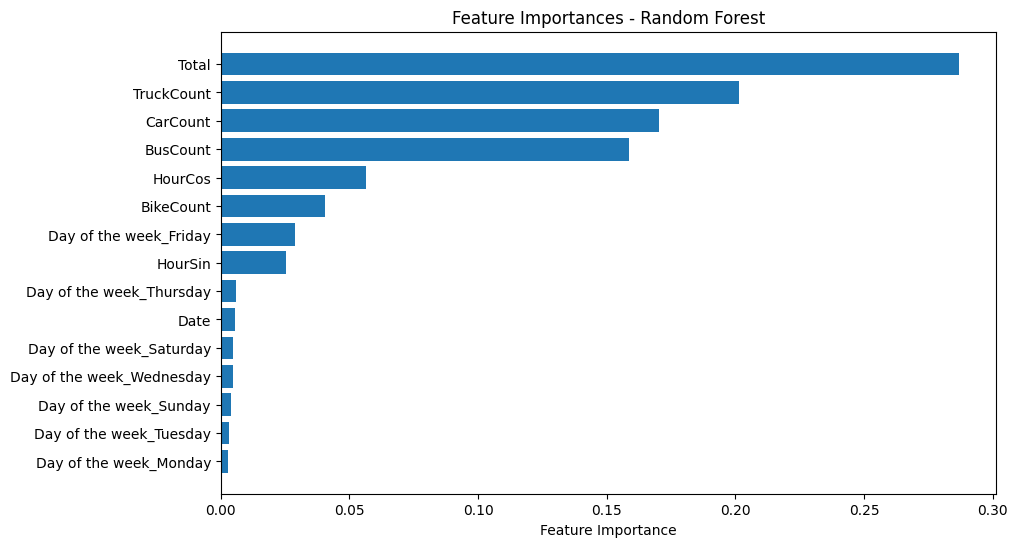

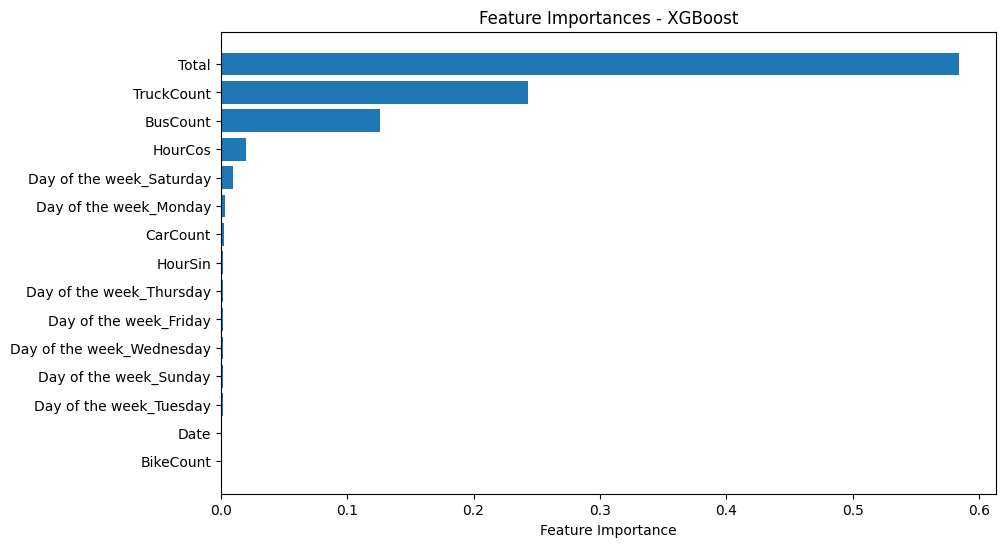

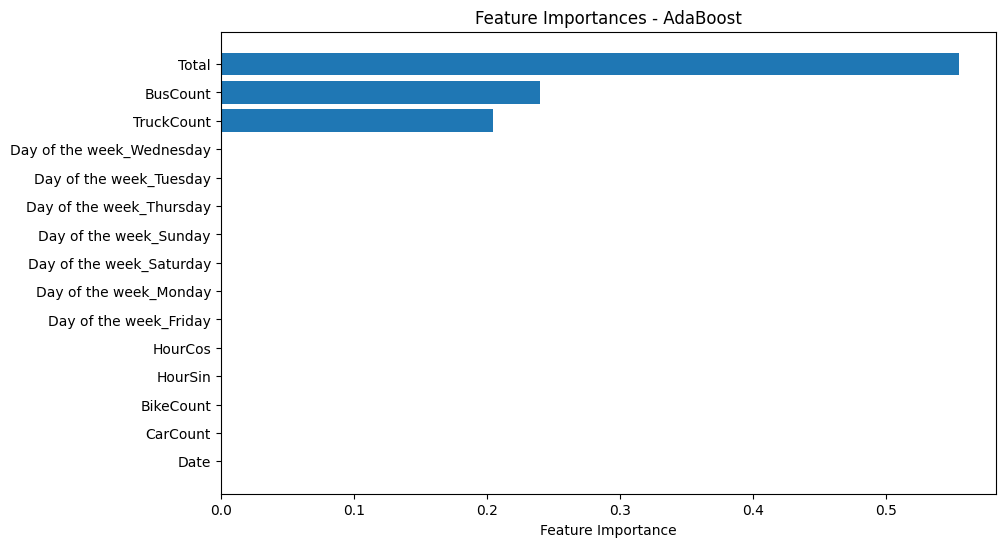

In [ ]:
# Plot Feature Importances (if applicable)

for clf, label in zip(classifiers, labels):
    # Check if the classifier supports feature importances
    if hasattr(clf, 'feature_importances_'):
        feature_importances = clf.feature_importances_
        feature_names = ['Date', 'CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total',
       'HourSin', 'HourCos', 'Day of the week_Friday',
       'Day of the week_Monday', 'Day of the week_Saturday',
       'Day of the week_Sunday', 'Day of the week_Thursday',
       'Day of the week_Tuesday', 'Day of the week_Wednesday']

        # Sort features by importance
        sorted_idx = np.argsort(feature_importances)

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
        plt.xlabel('Feature Importance')
        plt.title(f'Feature Importances - {label}')
        plt.show()


Neural Network Accuracy: 0.958832323551178
42/42 [==============================] - 0s 2ms/step


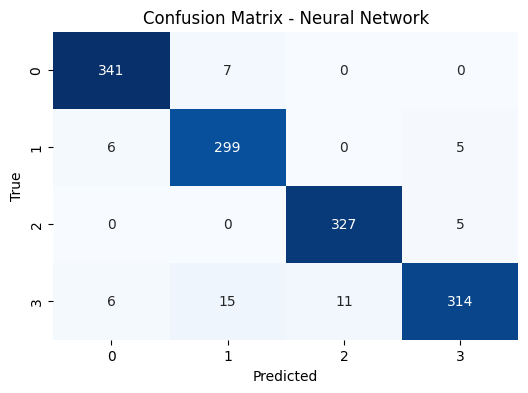

134/134 [==============================] - 0s 1ms/step


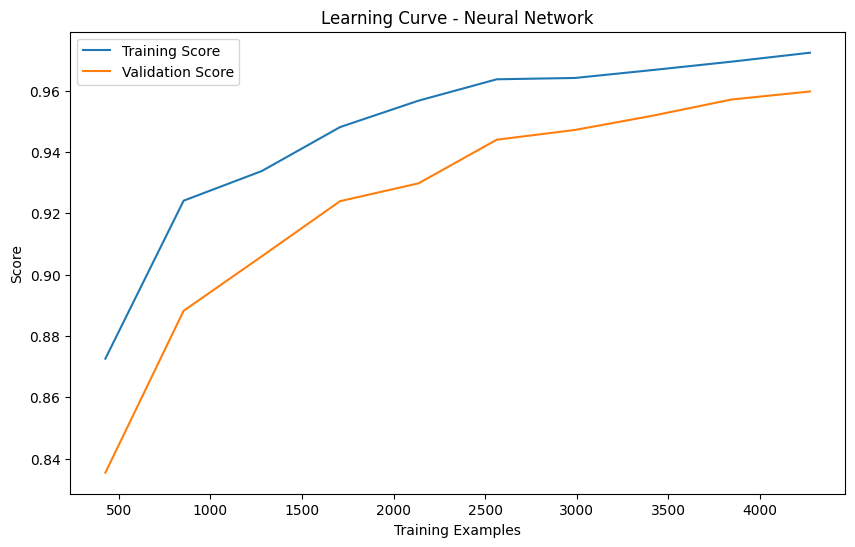

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define a simple neural network model
def create_nn_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))  # Assuming 4 classes for your traffic situation
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Convert the Keras model to a scikit-learn estimator
nn_cl = KerasClassifier(build_fn=create_nn_model, epochs=10, batch_size=32, verbose=0)

# Fit the neural network model
nn_cl.fit(X_train_scaled, y_train)

# Evaluate the performance on the test set
nn_accuracy = nn_cl.score(X_test_scaled, y_test)

# Print accuracy
print(f'Neural Network Accuracy: {nn_accuracy}')

# Confusion Matrix for Neural Network
nn_y_pred = nn_cl.predict(X_test_scaled)
nn_cm = confusion_matrix(y_test, nn_y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(nn_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Learning Curve for Neural Network
nn_train_sizes, nn_train_scores, nn_test_scores = learning_curve(
    nn_cl, X_train_scaled, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.figure(figsize=(10, 6))
plt.plot(nn_train_sizes, np.mean(nn_train_scores, axis=1), label='Training Score')
plt.plot(nn_train_sizes, np.mean(nn_test_scores, axis=1), label='Validation Score')
plt.title('Learning Curve - Neural Network')
plt.xlabel('Training Examples')
plt.ylabel('Score')
plt.legend()
plt.show()
